Установим одну внешнюю библиотеку для подключения к базе данных

In [1]:
!pip install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

## Воронка


### Выполнение запроса и получение датасета
Из таблицы `client` получим данные о посетителях страницы Тинькофф.Квест. Затем, с помощью операции `left join`, добавим информацию об аккаунтах из таблицы `account`.


Для создания датасета мы будем использовать SQL-запрос из базы данных.




In [3]:
query = """with clients_path as (
    select
        c.client_rk, c.visit_dttm as last_visit_dttm,
        a.account_rk, a.registration_dttm,
        ap.application_rk, ap.application_dttm,
        ap.game_rk, g.game_dttm, g.game_flg, g.finish_flg,
        g.price, g."time"
    from msu_analytics.client c
        left join msu_analytics.account a on c.client_rk = a.client_rk
        left join msu_analytics.application ap on a.account_rk = ap.account_rk
        left join msu_analytics.game g on ap.game_rk = g.game_rk
)

select * from clients_path
order by client_rk, application_dttm
"""

In [4]:
def execute_sql(query: str) -> pd.DataFrame:
    # Параметры подключения
    db_params = {
        "dbname": "postgres",
        "user": "student",
        "password": "JvLda93aA",
        "host": "158.160.52.106",
        "port": "5432"
    }

    # Создание подключения
    conn = psycopg2.connect(**db_params)

    # Выполнение запроса и преобразование результата в DataFrame
    data = pd.read_sql_query(query, conn)

    # Закрытие соединения
    conn.close()

    return data


def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    # Заполнение пропущенных значений и преобразование типа данных столбцов game_flg и finish_flg
    df['game_flg'] = df['game_flg'].fillna(0).astype(bool)
    df['finish_flg'] = df['finish_flg'].fillna(0).astype(bool)

    # Создание нового столбца passed_all_g_flg
    df['passed_all_g_flg'] = df.groupby('client_rk')['finish_flg'].transform('all')
    return df


# загрузка данных
df = execute_sql(query).pipe(data_preprocessing)

print(f"shape of the dataframe: {df.shape}")
df.head()

<ipython-input-4-789009f8b4c8>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, conn)


shape of the dataframe: (4315, 13)


,client_rk,last_visit_dttm,account_rk,registration_dttm,application_rk,application_dttm,game_rk,game_dttm,game_flg,finish_flg,price,time,passed_all_g_flg
0,1,2022-09-27 04:47:55.218228,NaN,NaT,NaN,NaT,NaN,NaT,False,False,NaN,None,False
1,2,2022-10-22 05:01:43.032205,NaN,NaT,NaN,NaT,NaN,NaT,False,False,NaN,None,False
2,3,2022-09-25 21:18:23.734588,12.0,2022-09-26 04:34:12.392193,NaN,NaT,NaN,NaT,False,False,NaN,None,False
3,4,2022-11-30 04:44:11.949916,801.0,2022-12-01 00:58:56.483252,75.0,2022-12-10 16:45:58.114216,22.0,2022-12-14 12:04:00.773186,True,True,2461.88,20:34:46,True
4,4,2022-11-30 04:44:11.949916,801.0,2022-12-01 00:58:56.483252,369.0,2022-12-13 14:14:16.594724,240.0,2023-01-02 05:14:31.462798,True,True,2531.29,05:49:32,True


Давайте рассмотрим, в какой период времени были проведены исследования.

In [5]:
# Выбирает все столбцы с именами, оканчивающимися на _dttm
dttm_cols = [col for col in df.columns if col.endswith('_dttm')]

# Вычисляет минимальную и максимальную даты для каждого выбранного столбца 
min_max_dates = df[dttm_cols].agg(['min', 'max']).T.apply(
    lambda x:
     f"{x['min'].strftime('%d %b %Y')} - {x['max'].strftime('%d %b %Y')}",
     axis=1
).to_frame(name='interval')

print(min_max_dates)

                                    interval
last_visit_dttm    01 Sep 2022 - 02 Feb 2023
registration_dttm  01 Sep 2022 - 02 Feb 2023
application_dttm   05 Sep 2022 - 01 Feb 2023
game_dttm          16 Sep 2022 - 27 Mar 2023


### Этапы
Определим этапы, которые мы будем отслеживать:

1. Количество регистраций на сайте Тинькофф.Квест
2. Количество клиентов, которые подали хотя бы одну заявку на игру
3. Количество клиентов, у которых состоялась хотя бы одна игра
4. Количество клиентов, у которых пройдена хотя бы одна игра
5. Количество клиентов, у которых пройдены все игры, в которых они участвовали

In [6]:
# Давайте определим возможные целевые действия, которые мы хотим отслеживать:

# Количество клиентов, посетившие сайт Тинькофф.Квест
client_visited = df["client_rk"].nunique()

# 1. Количество регистраций на сайте Тинькофф.Квест
client_registered = df["account_rk"].nunique()

# 2. Количество клиентов, которые подали хотя бы одну заявку на игру
client_applied = df.loc[df["application_rk"].notnull(), "client_rk"].nunique()


# 3.Количество клиентов, у которых состоялась хотя бы одна игра
client_played = df[df["game_flg"] == True]["account_rk"].nunique()

# 4. Количество клиентов, у которых пройдена хотя бы одна игра
client_passed_min_one = df[df["finish_flg"] == True]["account_rk"].nunique()

# 5. Количество клиентов, у которых пройдены все игры, в которых они участвовали
client_passed_all = df[df["passed_all_g_flg"] == True]["client_rk"].nunique()


client_number = [
    client_visited,
    client_registered,
    client_applied,
    client_played,
    client_passed_min_one,
    client_passed_all,
]

phase_pretty_names = [
    "Количество клиентов, посетившие сайт Тинькофф.Квест",
    "Количество регистраций на сайте Тинькофф.Квест",
    "Количество клиентов, которые подали хотя бы одну заявку на игру",
    "Количество клиентов, у которых состоялась хотя бы одна игра",
    "Количество клиентов, у которых пройдена хотя бы одна игра", 
    "Количество клиентов, у которых пройдены все игры,\
в которых они участвовали"
]

phase_columns_names = [
    "client_visited", "client_registered", "client_applied",
    "client_played", "client_passed_min_one",
    "client_passed_all"
]

### Воронка за весь доступный период

Давайте изучим общую динамику конверсии клиентов на сайте Тинькофф.Квест. Для этого мы возьмем всех пользователей, которые посетили сайт, как начальную фазу.





In [7]:
def get_conversion(df: pd.DataFrame) -> pd.DataFrame:
    conv_col = df.columns[1]
    funnel_start_phase = df.loc[0, conv_col]
    initial_conversion = df[conv_col] * 100 / funnel_start_phase
    previous_conversion = df[conv_col] * 100 / \
                  df[conv_col].shift(1).fillna(funnel_start_phase)
    df["initial_conversion"] = initial_conversion .round(2)
    df["previous_conversion"] = previous_conversion.round(2)
    
    return df

In [8]:
overall_funnel = pd.DataFrame({
    "Этап": phase_pretty_names,
    "Число клиентов": client_number
})
# Применение функции get_conversion
overall_funnel = get_conversion(overall_funnel)

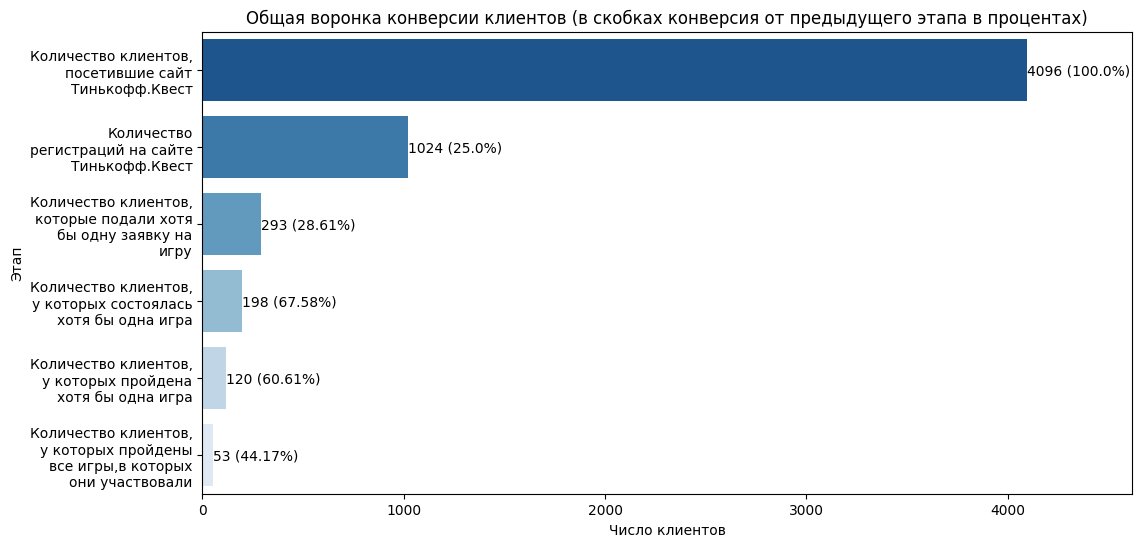

In [9]:
# Создание фигуры и оси с большим размером
fig, ax = plt.subplots(figsize=(12, 6))  # измените значения (12, 6) для настройки размера фигуры

# Построение графика
sns.barplot(
    x="Число клиентов",
    y="Этап",
    data=overall_funnel,
    orient="h",
    ax=ax,
    palette="Blues_r",
)

# Добавление процентов на график
for i, (value, percent) in enumerate(zip(overall_funnel["Число клиентов"],
                                         overall_funnel["previous_conversion"])):
    ax.text(value, i, f"{value} ({percent}%)", ha="left", va="center")

# Задание названия графика и оси Y
ax.set_title("Общая воронка конверсии клиентов \
(в скобках конверсия от предыдущего этапа в процентах)")
ax.set_xlabel("Число клиентов")

# Увеличение границы оси X
ax.set_xlim(0, max(overall_funnel["Число клиентов"]) * 1.1275)

# Обновление меток оси Y с переносом текста
wrapped_labels = [textwrap.fill(label, width=20) for label in overall_funnel["Этап"]]
ax.set_yticklabels(wrapped_labels)

# Отображение графика
plt.show()


In [10]:
overall_funnel

,Этап,Число клиентов,initial_conversion,previous_conversion
0,"Количество клиентов, посетившие сайт Тинькофф....",4096,100.00,100.00
1,Количество регистраций на сайте Тинькофф.Квест,1024,25.00,25.00
2,"Количество клиентов, которые подали хотя бы од...",293,7.15,28.61
3,"Количество клиентов, у которых состоялась хотя...",198,4.83,67.58
4,"Количество клиентов, у которых пройдена хотя б...",120,2.93,60.61
5,"Количество клиентов, у которых пройдены все иг...",53,1.29,44.17


Только четверть клиентов, которые посетили сайт, зарегистрировались. Хотя этот показатель может быть нормальным, мы можем попытаться его улучшить, например, ускорив процесс регистрации.

## Конверсии от начальной фазы



In [11]:
def add_conversion(df: pd.DataFrame) -> pd.DataFrame:
    start = df.columns[1]
    client_number = df.columns[2:]
    for i in client_number:
        df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)

    return df

In [12]:
MONTH_FMT = "%b %Y"
WEEK_FMT = "%V %b-%Y"

def group_by_period(
    df: pd.DataFrame,
    dttm: str,
    period: str,
    client_number_func: list[callable],
    alias_lst: list[str],
    offset: str = "0h",
    closed: str = "left",
) -> pd.DataFrame:

    df[dttm] = pd.to_datetime(df[dttm])

    if period == "month":
        freq = 'M'
    elif period == "week":
        freq = 'W'
    else:
        raise ValueError("Wrong `period` value")
    
    # Создание столбца с интервалами времени на основе аргументов
    df[period] = df[dttm].dt.to_period(freq).dt.to_timestamp() +  \
                        pd.to_timedelta(offset)

    # Группировка
    grouped = df.groupby(period)
    
    # Вычисление значений client_number для каждой группы
    results = []
    for group_name, group_df in grouped:
        row = [group_name] + [func(group_df) for func in client_number_func]
        results.append(row)
    
    # Создание нового датафрейма с полученными значениями
    result = pd.DataFrame(results, columns=[period] + alias_lst)

    # Форматирование столбца времени
    date_fmt = MONTH_FMT if period == "month" else WEEK_FMT
    result[period] = result[period].dt.strftime(date_fmt)

    return result



In [13]:
def plot_conversion(
    df: pd.DataFrame, legend: list[str],
    title: str, ytitle: str, rotate_xtick=True
) -> None:
    
    label_col = df.columns[0]
    cols = df.filter(regex="_conversion$").columns
    plt.figure(figsize=(15, 6))  # Устанавливаем размер графика
    wrapped_legend = [textwrap.fill(label, width=20) for label in legend] 
    for c, name in zip(cols, wrapped_legend):
        sns.lineplot(x=label_col, y=c, data=df, marker='o', label=name)
    
    plt.title(title, x=0, y=1.05, ha='left', fontsize=16)


    plt.ylabel(ytitle)
    
    if rotate_xtick:
        plt.xticks(rotation=-70)
    # Располагаем легенду справа от графика

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
    plt.tight_layout()
    plt.show()


### Конверсия по месяцам все этапы

In [14]:
# Определение функций для client_number
def client_visited(group_df: pd.DataFrame) -> int:
    return group_df["client_rk"].nunique()

def client_registered(group_df: pd.DataFrame) -> int:
    return group_df["account_rk"].nunique()

def client_applied(group_df: pd.DataFrame) -> int:
    return group_df.loc[group_df["application_rk"].notnull(), "client_rk"].nunique()

def client_played(group_df: pd.DataFrame) -> int:
    return group_df[group_df["game_flg"] == True]["account_rk"].nunique()

def client_passed_min_one(group_df: pd.DataFrame) -> int:
    return group_df[group_df["finish_flg"] == True]["account_rk"].nunique()

def client_passed_all(group_df: pd.DataFrame) -> int:
    return group_df[group_df["passed_all_g_flg"] == True]["client_rk"].nunique()

client_number_func = [
    client_visited,
    client_registered,
    client_applied,
    client_played,
    client_passed_min_one,
    client_passed_all,
]

# Группировка
users_by_month = group_by_period(
    df, "last_visit_dttm",
    "month", client_number_func, phase_columns_names
)

# Фильтрация 
users_by_month = users_by_month[users_by_month["month"] != "Feb 2023"]

# Посчитаем конверсии
users_by_month = add_conversion(users_by_month)

users_by_month


,month,client_visited,client_registered,client_applied,client_played,client_passed_min_one,client_passed_all,client_registered_conversion,client_applied_conversion,client_played_conversion,client_passed_min_one_conversion,client_passed_all_conversion
0,Sep 2022,778,190,51,39,23,11,24.42,6.56,5.01,2.96,1.41
1,Oct 2022,843,217,65,56,30,14,25.74,7.71,6.64,3.56,1.66
2,Nov 2022,786,200,56,50,34,15,25.45,7.12,6.36,4.33,1.91
3,Dec 2022,805,196,57,33,19,8,24.35,7.08,4.10,2.36,0.99
4,Jan 2023,852,213,64,20,14,5,25.00,7.51,2.35,1.64,0.59


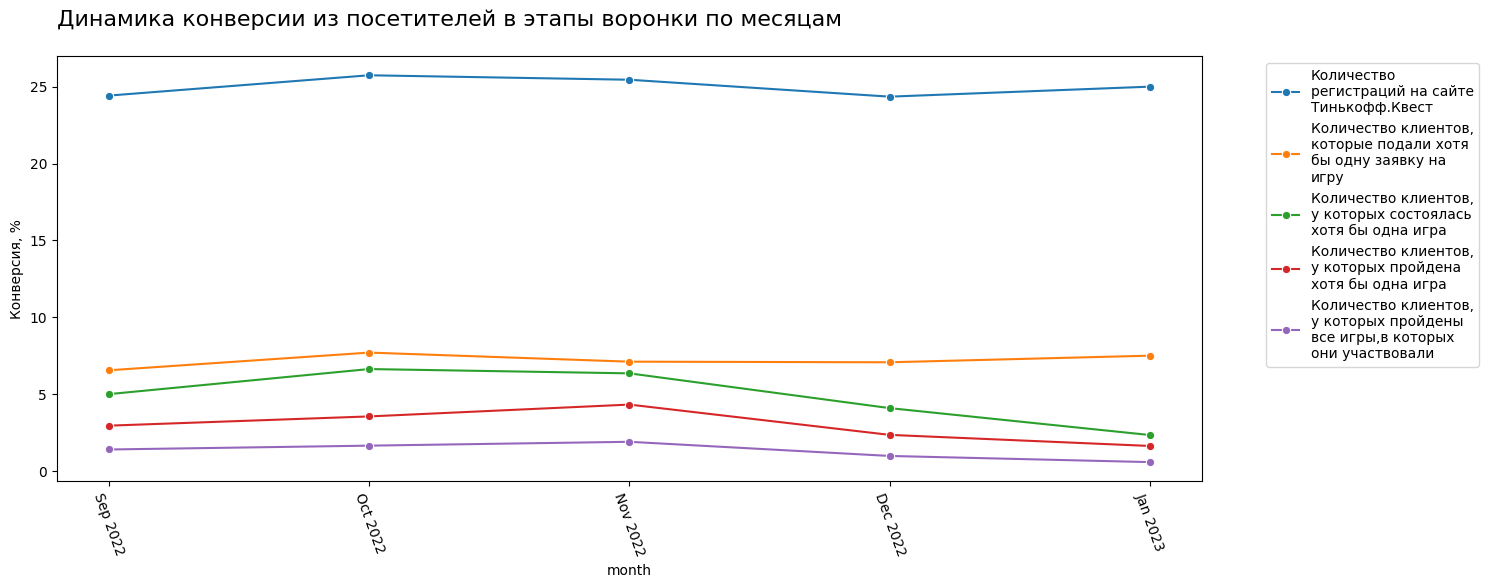

In [15]:
plot_conversion(
    users_by_month,
    phase_pretty_names[1:],
    "Динамика конверсии из посетителей в этапы воронки по месяцам",
    "Конверсия, %"
)

### Конверсия по неделям все этапы

In [16]:
# Группировка
users_by_week = group_by_period(
    df, "last_visit_dttm",
    "week", client_number_func, phase_columns_names
)

# Фильтрация
users_by_week = users_by_week[users_by_week["week"] != "05 Jan-2023"]

# Посчитаем конверсии
users_by_week = add_conversion(users_by_week)

users_by_week.head()


,week,client_visited,client_registered,client_applied,client_played,client_passed_min_one,client_passed_all,client_registered_conversion,client_applied_conversion,client_played_conversion,client_passed_min_one_conversion,client_passed_all_conversion
0,35 Aug-2022,111,32,7,5,2,0,28.83,6.31,4.50,1.80,0.00
1,36 Sep-2022,184,31,6,5,2,2,16.85,3.26,2.72,1.09,1.09
2,37 Sep-2022,167,43,16,8,5,2,25.75,9.58,4.79,2.99,1.20
3,38 Sep-2022,181,45,12,11,9,5,24.86,6.63,6.08,4.97,2.76
4,39 Sep-2022,195,59,17,17,9,4,30.26,8.72,8.72,4.62,2.05


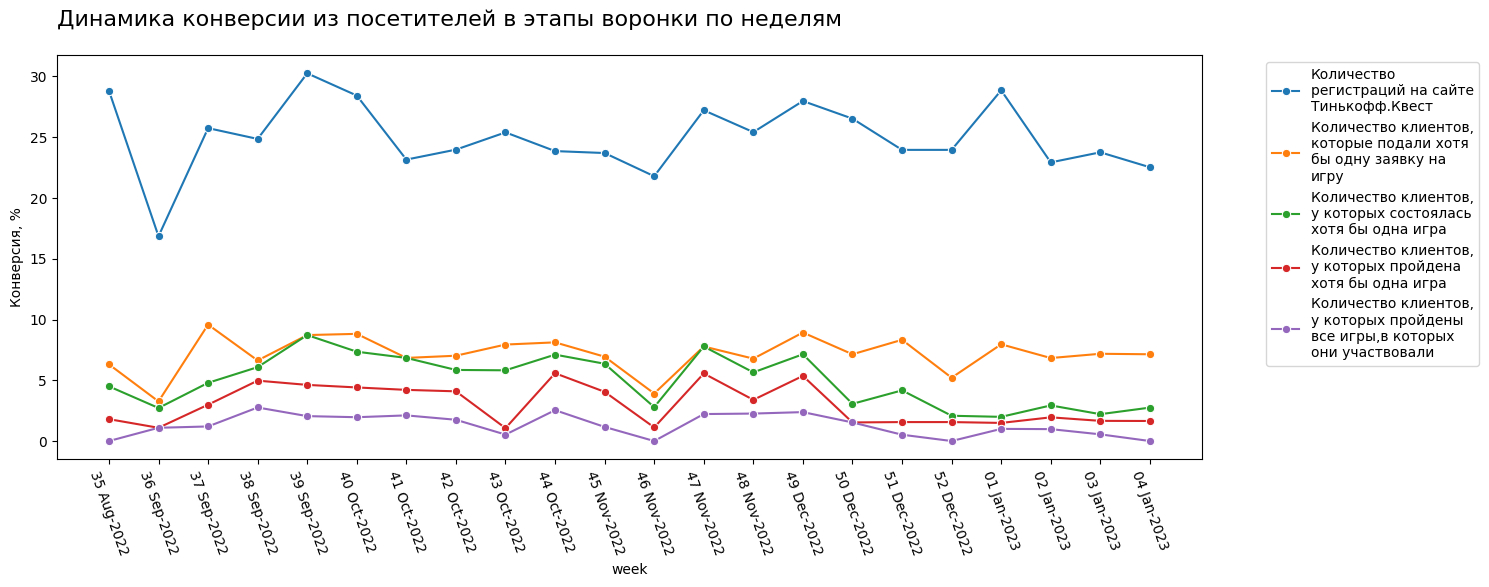

In [17]:
plot_conversion(
    users_by_week,
    phase_pretty_names[1:],
    "Динамика конверсии из посетителей в этапы воронки по неделям",
    "Конверсия, %"
)

### Конверсии без финального этапа

In [18]:
def phases_without_final(df: pd.DataFrame, period: str):
    # month/week
    kwargs = {"df": df, "period": period}
    
    return group_by_period(
        dttm="last_visit_dttm",
        client_number_func=[client_visited], alias_lst=[phase_pretty_names[0]], **kwargs
    ).merge(group_by_period(
        dttm="registration_dttm",
        client_number_func=[client_registered], alias_lst=[phase_pretty_names[1]], **kwargs
    ), on=f"{period}", how="left"
    ).merge(group_by_period(
        dttm="application_dttm",
        client_number_func=[client_applied], alias_lst=[phase_pretty_names[2]], **kwargs
    ), on=f"{period}", how="left"
    ).merge(group_by_period(
        dttm="game_dttm",
        client_number_func=[client_played], alias_lst=[phase_pretty_names[3]], **kwargs
    ), on=f"{period}", how="left"
    ).merge(group_by_period(
        dttm="game_dttm",
        client_number_func=[client_passed_min_one], alias_lst=[phase_pretty_names[4]], **kwargs
    ), on=f"{period}", how="left"
    )

<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)
<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)
<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

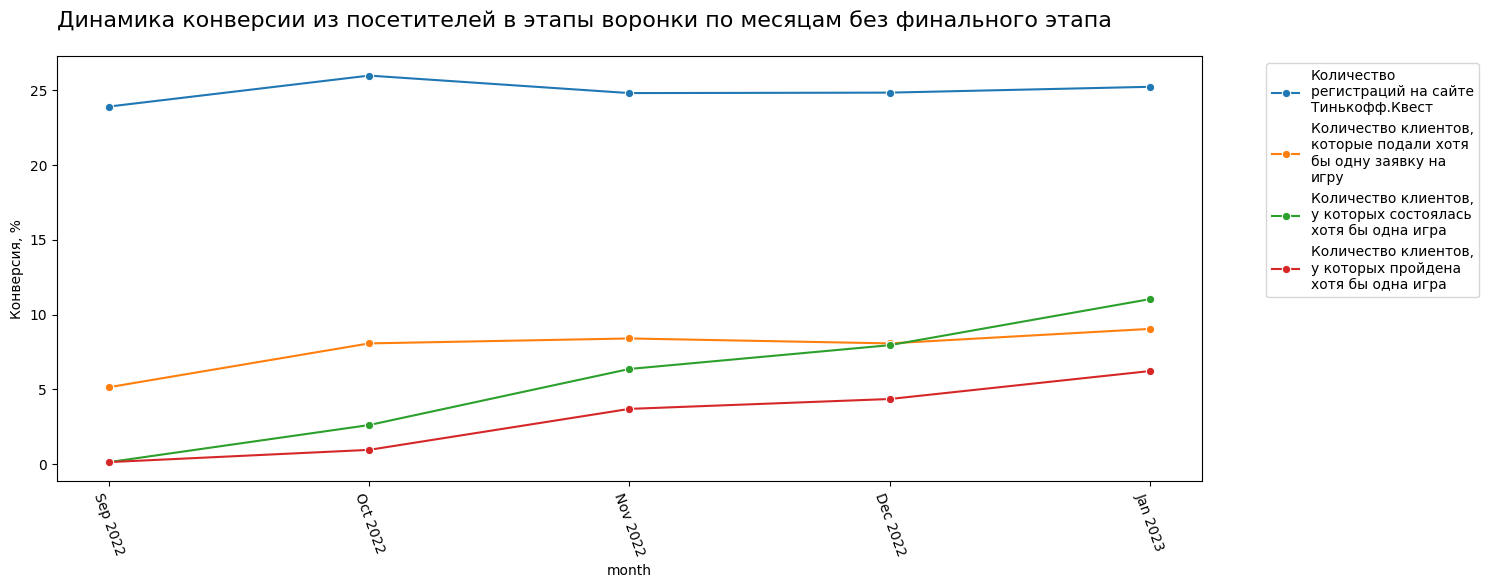

In [19]:
by_month = phases_without_final(df, "month")
by_month = by_month[by_month["month"] != "Feb 2023"].pipe(add_conversion)

plot_conversion(
    by_month,
    phase_pretty_names[1:-1],
    "Динамика конверсии из посетителей в этапы воронки\
 по месяцам без финального этапа",
    "Конверсия, %"
)

<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)
<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)
<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

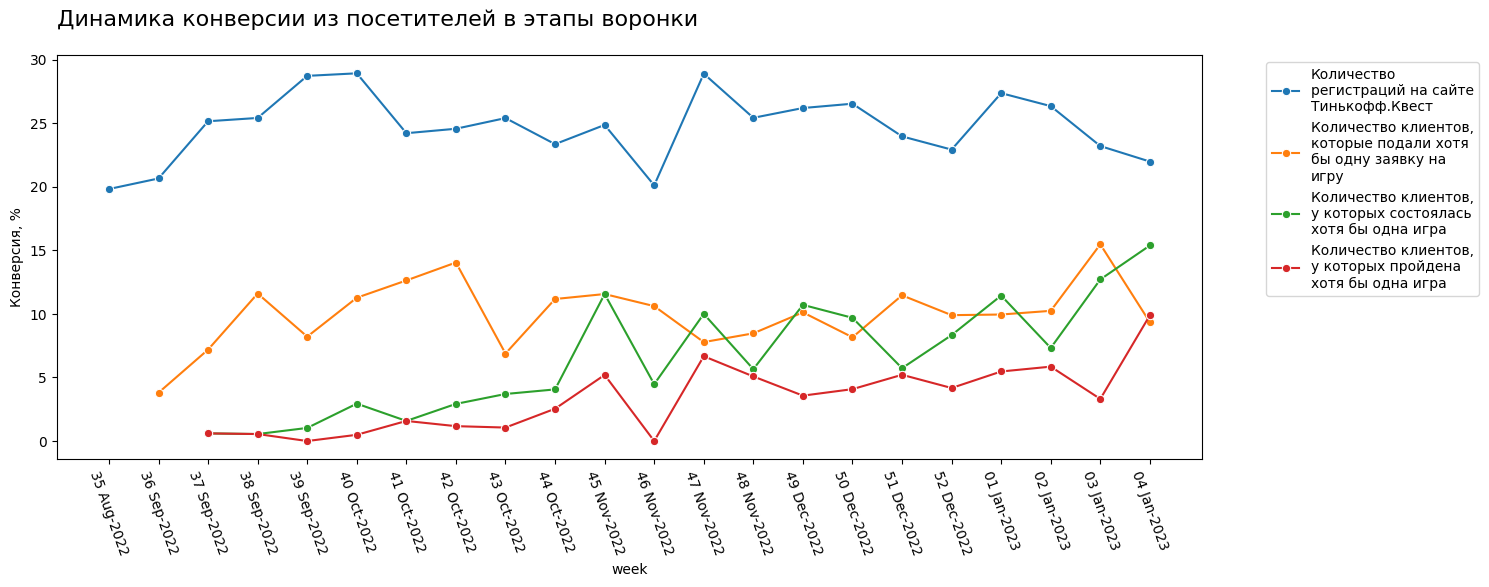

In [20]:
by_week = phases_without_final(df, "week")
by_week = by_week[by_week["week"] != "05 Jan-2023"].pipe(add_conversion)

plot_conversion(
    by_week,
    phase_pretty_names[1:-1],
    "Динамика конверсии из посетителей в этапы воронки",
    "Конверсия, %"
)

<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)
<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'{i}_conversion'] = (df[i] * 100 / df[start]).round(2)
<ipython-input-11-bb8ad7d653c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

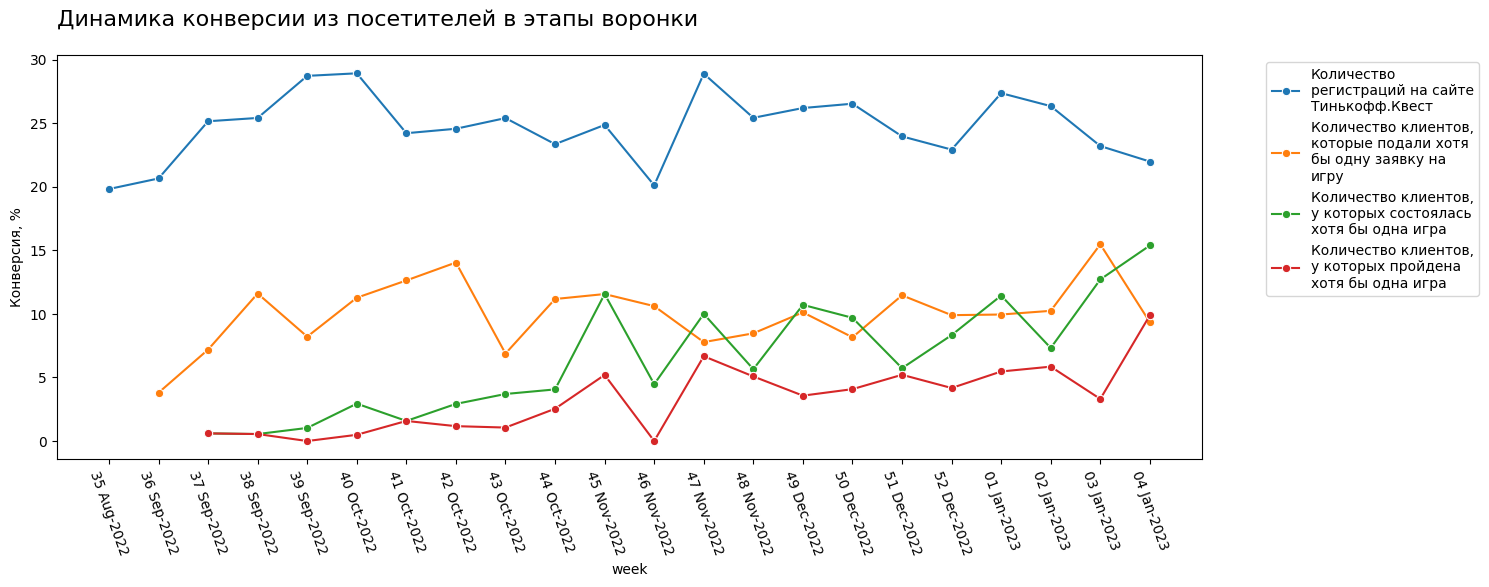

In [21]:
by_week = phases_without_final(df, "week")
by_week = by_week[by_week["week"] != "05 Jan-2023"].pipe(add_conversion)

plot_conversion(
    by_week,
    phase_pretty_names[1:-1],
    "Динамика конверсии из посетителей в этапы воронки",
    "Конверсия, %"
)

### Конверсия от заявок на игру

In [22]:
kwargs = {"df": df, "period": "month"}
def application_rk_nunique(group_df: pd.DataFrame) -> int:
    return group_df["application_rk"].nunique()

def game_flg_sum(group_df: pd.DataFrame) -> int:
    return group_df["game_flg"].sum()

def finish_flg_sum(group_df: pd.DataFrame) -> int:
    return group_df["finish_flg"].sum()

applied_start = group_by_period(
    dttm="application_dttm",
   client_number_func=[application_rk_nunique], alias_lst=["apps"], **kwargs
).merge(group_by_period(
    dttm="game_dttm",
    client_number_func=[game_flg_sum], alias_lst=["started_games"], **kwargs
), on="month", how="left"
).merge(group_by_period(
    dttm="game_dttm",
    client_number_func=[finish_flg_sum], alias_lst=["finished_games"], **kwargs
), on="month", how="left"
).pipe(add_conversion)

applied_start

,month,apps,started_games,finished_games,started_games_conversion,finished_games_conversion
0,Sep 2022,63,2,2,3.17,3.17
1,Oct 2022,109,24,8,22.02,7.34
2,Nov 2022,107,58,30,54.21,28.04
3,Dec 2022,97,70,36,72.16,37.11
4,Jan 2023,133,106,55,79.70,41.35
5,Feb 2023,3,4,2,133.33,66.67


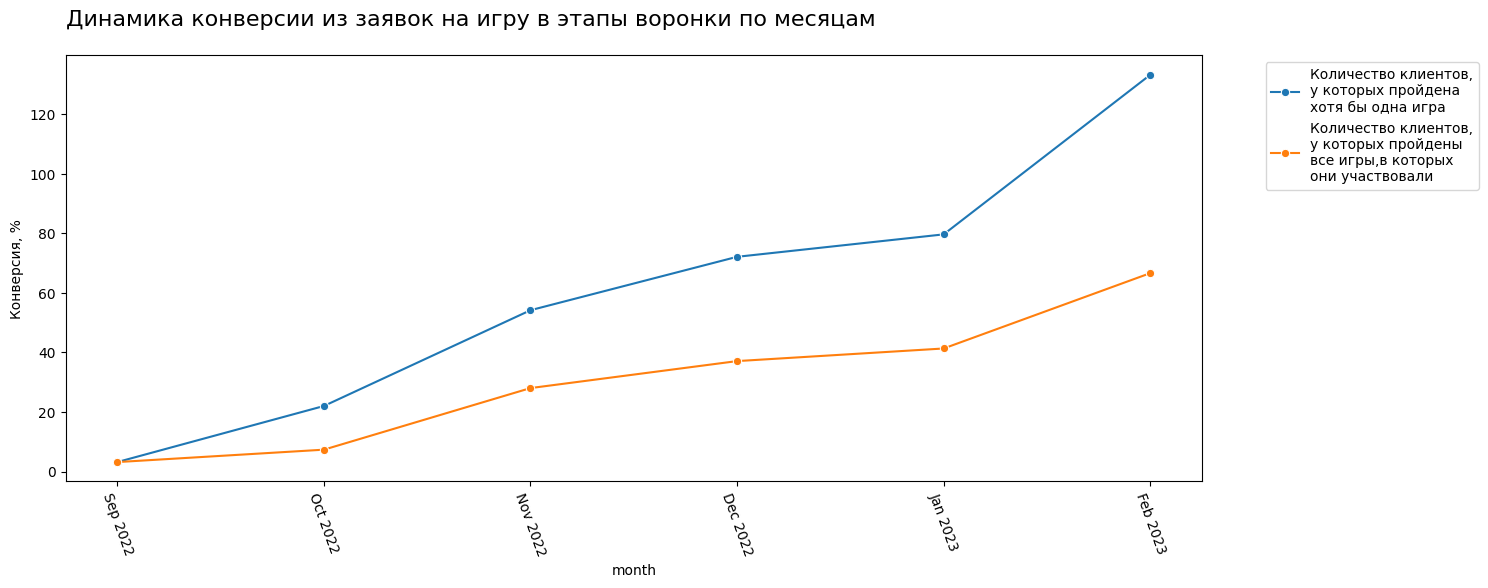

In [23]:
plot_conversion(
    applied_start,
     phase_pretty_names[-2:],
    "Динамика конверсии из заявок на игру в этапы воронки по месяцам",
    "Конверсия, %"
)

In [24]:
kwargs = {"df": df, "period": "week"}
on_col = "week"

applied_start = group_by_period(
    dttm="application_dttm",
     client_number_func=[application_rk_nunique], alias_lst=["apps"], **kwargs
).merge(group_by_period(
    dttm="game_dttm",
     client_number_func=[game_flg_sum], alias_lst=["started_games"], **kwargs
), on=on_col, how="left"
).merge(group_by_period(
    dttm="game_dttm",
    client_number_func=[finish_flg_sum], alias_lst=["finished_games"], **kwargs
), on=on_col, how="left"
).pipe(add_conversion)

applied_start.head()

,week,apps,started_games,finished_games,started_games_conversion,finished_games_conversion
0,36 Sep-2022,7,NaN,NaN,NaN,NaN
1,37 Sep-2022,17,1.0,1.0,5.88,5.88
2,38 Sep-2022,24,1.0,1.0,4.17,4.17
3,39 Sep-2022,18,2.0,0.0,11.11,0.00
4,40 Oct-2022,33,6.0,1.0,18.18,3.03


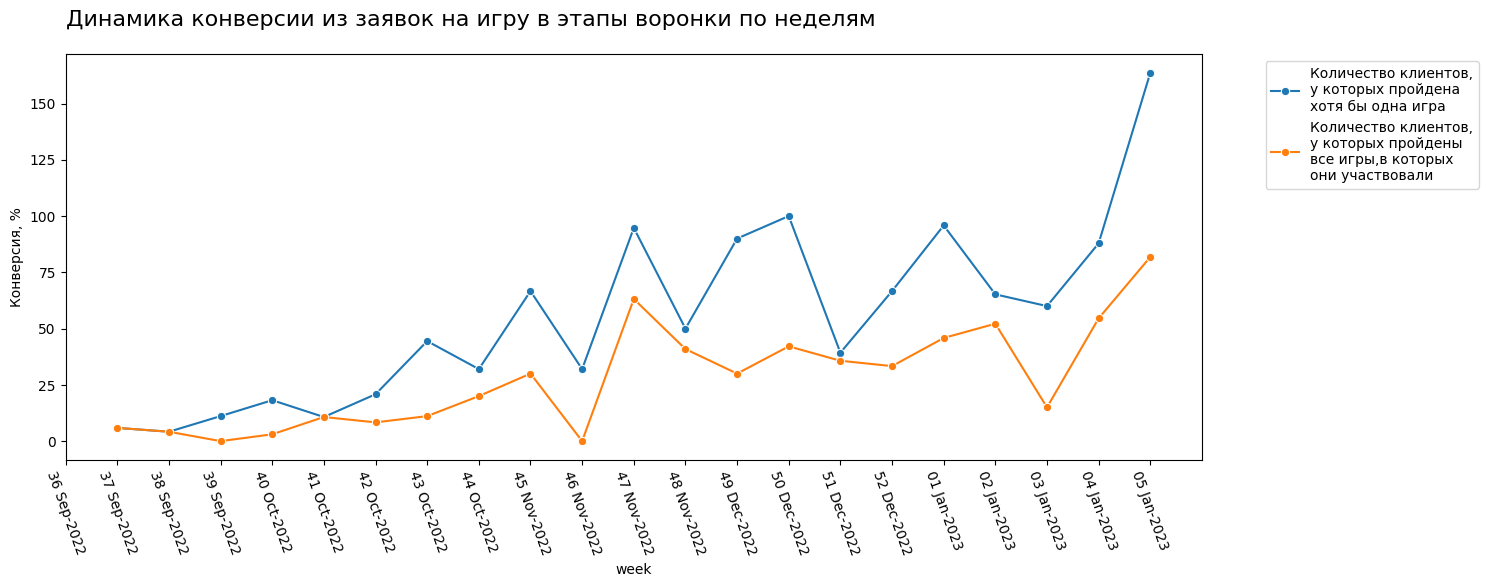

In [25]:
plot_conversion(
    applied_start,
     phase_pretty_names[-2:],
    "Динамика конверсии из заявок на игру в этапы воронки по неделям",
    "Конверсия, %"
)